<a href="https://colab.research.google.com/github/the-faisalahmed/Optimization/blob/main/Light_Up_Akari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
import sys
import os

if 'google.colab' in sys.modules:
    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin
    os.environ['PATH'] += ':bin'

!pip install pyomo
from pyomo.environ import *
from pyomo.opt import SolverFactory
from pyomo.util.infeasible import log_infeasible_constraints
from pyomo.opt import SolverStatus
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
from pyomo.contrib.latex_printer import latex_printer

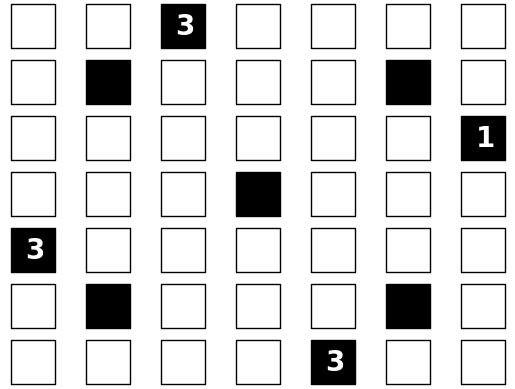

In [123]:
n = 7
size = 1000

blocked = {(5,1): 3,
           (2,2): 0, (6,2): 0,
           (1,3): 3,
           (4,4): 0,
           (7,5): 1,
           (2,6): 0, (6,6): 0,
           (3,7): 3}

num = {}

for i in blocked:
  if blocked[i] > 0:
    num[i] = blocked[i]

for i,j in list(itertools.product(list(range(1,n+1)),list(range(1,n+1)))):
  if (i,j) in blocked.keys():
    if blocked[i,j] > 0:
      plt.scatter(i,j,marker = 's',s=size, c='k', clip_on=False);
      plt.text(i-.1,j-.15,blocked[i,j], fontsize = 20, color = '#FFFFFF', weight = 'semibold');
    else:
      plt.scatter(i,j,marker = 's',s=size, c='k', clip_on=False);
  else:
    plt.scatter(i,j,marker = 's',s=size, c='#FFFFFF', edgecolor = 'k', clip_on=False);

plt.axis('off');

#plt.savefig('pic1.png')


In [42]:
blocked

{(5, 1): 3,
 (2, 2): 0,
 (6, 2): 0,
 (1, 3): 3,
 (4, 4): 0,
 (7, 5): 1,
 (2, 6): 0,
 (6, 6): 0,
 (3, 7): 3}

In [118]:
model = ConcreteModel()

model.I = RangeSet(1,n)
model.x = Var(model.I, model.I, within = Binary)
model.param = Param(model.I, model.I, initialize = num)

for (i,j) in blocked:
  model.x[i,j].fix(0)

# Rows must sum to one
model.cons1 = ConstraintList()
for j in model.I:
  area = []
  for i in model.I:
    if (i,j) not in blocked:
      area.append((i,j))
    elif (i,j) in blocked and len(area) > 0:
      model.cons1.add(sum(model.x[v] for v in area) <= 1)
      area = []
    elif (i,j) in blocked and len(area) < 0:
      area = []

    if i == len(model.I) and len(area) > 0:
      model.cons1.add(sum(model.x[v] for v in area) <= 1)
      area = []

# Columns must sum to one
model.cons2 = ConstraintList()
for i in model.I:
  area = []
  for j in model.I:
    if (i,j) not in blocked:
      area.append((i,j))
    elif (i,j) in blocked and len(area) > 0:
      model.cons2.add(sum(model.x[v] for v in area) <= 1)
      area = []
    elif (i,j) in blocked and len(area) < 0:
      area = []

    if j == len(model.I) and len(area) > 0:
      model.cons2.add(sum(model.x[v] for v in area) <= 1)
      area = []

# Sum parameters for blocked areas
model.cons3 = ConstraintList()

for (i,j) in list(model.param.keys()):
  v = []
  for (w,x) in [(1,0),(0,1),(-1,0),(0,-1)]:
    if (i+w,j+x) in list(model.x.keys()):
      v.append((i+w,j+x))
  model.cons3.add(model.param[i,j] == sum(model.x[k] for k in v))


model.obj = Objective(expr = sum(model.x[i,j] for i in model.I for j in model.I),sense = maximize)


In [ ]:
#Optimization problem in latex form

#latex_printer(model)

In [119]:
# Solve model
opt = SolverFactory('cbc')
result = opt.solve(model)

if (result.solver.status == SolverStatus.ok) and \
    (result.solver.termination_condition == TerminationCondition.optimal):
    # Do something when the solution in optimal and feasible
    print('Solution is Optimal')
elif (result.solver.termination_condition == TerminationCondition.infeasible):
    # Do something when model in infeasible
    print('Solution is Infeasible')
else:
        # Something else is wrong
    print("Solver Status:",  result.solver.status)

# Solve time
print('Solve Time: ', result.solver.wallclock_time)

Solution is Optimal
Solve Time:  0.0


In [120]:
sol = model.x.extract_values()

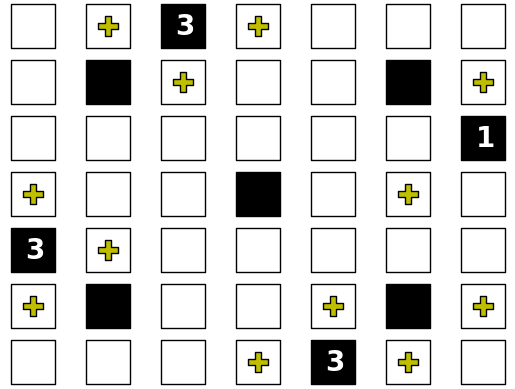

In [124]:
for i,j in list(itertools.product(list(range(1,n+1)),list(range(1,n+1)))):
  if (i,j) in blocked.keys():
    if blocked[i,j] > 0:
      plt.scatter(i,j,marker = 's',s=size, c='k', clip_on=False);
      plt.text(i-.1,j-.15,blocked[i,j], fontsize = 20, color = '#FFFFFF', weight = 'semibold');
    else:
      plt.scatter(i,j,marker = 's',s=size, c='k', clip_on=False);
  elif sol[i,j] > 0:
    plt.scatter(i,j,marker = 's',s=size, c='w', edgecolor = 'k', clip_on=False)
    plt.scatter(i,j, marker = "P", s = 200, color = 'y', edgecolor = 'k')
  else:
    plt.scatter(i,j,marker = 's',s=size, c='w', edgecolor = 'k', clip_on=False);

plt.axis('off');
#plt.savefig('pic2.png')
